## Animation

This notebook is fro creating animation from timeeries of NAO indices, SST, surface heat flux anomaly etc. data. 

In [1]:
# Load libraries

import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar, visualize

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, levels=9, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
        
    p = da.plot.contourf(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, levels = levels, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False, extend='both')
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.6) # orientation="horizontal"
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    ax.add_feature(cfeature.LAND) #facecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig, cb 

In [7]:
# Read Data

tim_ind = 4

ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Composite/time_series/"

ds_NAOp = xr.open_mfdataset(ppdir + "JFM_ind_" + str(tim_ind) + "/*NAOp*.nc")

ds_NAOn = xr.open_mfdataset(ppdir + "JFM_ind_" + str(tim_ind) + "/*NAOn*.nc")

tauu_NAOp = xr.open_mfdataset(ppdir + "JFM_ind_" + str(tim_ind) + "/*NAOp_tauu.nc")
tauu_NAOn = xr.open_mfdataset(ppdir + "JFM_ind_" + str(tim_ind) + "/*NAOn_tauu.nc")

print(ds_NAOp)

<xarray.Dataset>
Dimensions:    (j: 450, i: 450, time: 125, lat: 649, lon: 864)
Coordinates:
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
  * time       (time) object 1960-11-16 00:00:00 ... 1971-03-16 00:00:00
  * lat        (lat) float64 -90.0 -89.72 -89.44 -89.17 ... 89.44 89.72 90.0
  * lon        (lon) float64 0.0 0.4167 0.8333 1.25 ... 358.3 358.7 359.2 359.6
Data variables:
    hfds       (time, j, i) float32 dask.array<chunksize=(125, 450, 450), meta=np.ndarray>
    mlotst     (time, j, i) float32 dask.array<chunksize=(125, 450, 450), meta=np.ndarray>
    sos        (time, j, i) float32 dask.array<chunksize=(125, 450, 450), meta=np.ndarray>
    tauu       (time, lat, lon) float32 dask.array<chunksize=(125, 649, 

In [8]:
ds_NAOp['time.month']

<xarray.DataArray 'month' (time: 125)>
array([11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12,  1,  2,  3])
Coordinates:
  * time     (time) object 1960-11-16 00:00:00 ... 1971-03-16 00:00:00

### NAO indices

We isolate the NAO indices for the timeseries.  

In [12]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/NAO/"

ds_NAO = xr.open_dataset(ppdir + "NAO_SLP_Anomaly.nc")

NAO_season = ds_NAO['NAO'].copy()
tim = ds_NAO['time_val'].isel(start_year=0).drop('start_year')
NAO_season = NAO_season.assign_coords(time=tim)

NAO_season = NAO_season.isel(time=slice(1,len(NAO_season.time)-1)) # get rid of first Nov and last Mar for better seasonal avg

NAO_season = NAO_season.resample(time='QS-DEC').mean('time').compute()

In [13]:
NAO_cut = 2.5

NAOp = ds_NAO['NAO'].where(NAO_season.isel(time=tim_ind) >= NAO_cut)

NAOn = ds_NAO['NAO'].where(NAO_season.isel(time=tim_ind) <= -NAO_cut)

#print(NAOp)

#### Overturning Data

In [14]:
ppdir="/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/"

# variable list to keep in the dataset
var_list = ['hfbasin_atlantic', 'sltbasin_atlantic', 'zomsfatl']

ds = xr.open_dataset(ppdir+"Overturning_z.nc", decode_times=False, chunks={'r':1, 'y':1})
ds = ds.get(var_list)
ds = xr.decode_cf(ds)

ppdir_drift="/home/users/hkhatri/DePreSys4_Data/Data_Drift_Removal/Drift_1970_2016_Method_DCPP/"

ds_drift = []

for lead_year in range(0, 11):
    
    d = xr.open_dataset(ppdir_drift + "diaptr/" + "Drift_diaptr_Lead_Year_" + 
                        str(lead_year + 1) + ".nc", decode_times= False)
    d = d.assign(time_counter = np.arange(lead_year*12, 12*lead_year + np.minimum(12, len(d['time_counter'])), 1))
    
    ds_drift.append(d)
    
ds_drift = xr.concat(ds_drift, dim='time_counter')

ds_drift = ds_drift.get(var_list)

ds_anom = ds.drop('time_counter')  - ds_drift.drop(['time_counter','start_year'])

print(ds_anom)

<xarray.Dataset>
Dimensions:            (depthw: 75, y: 451, x: 1, start_year: 57, r: 10, time_counter: 125)
Coordinates:
  * depthw             (depthw) float32 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
    nav_lat            (y, x) float32 3.997 4.246 4.495 ... 79.85 79.92 79.99
    nav_lon            (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * start_year         (start_year) int64 1960 1961 1962 1963 ... 2014 2015 2016
Dimensions without coordinates: y, x, r, time_counter
Data variables:
    hfbasin_atlantic   (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 1, 125, 1, 1), meta=np.ndarray>
    sltbasin_atlantic  (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 1, 125, 1, 1), meta=np.ndarray>
    zomsfatl           (start_year, r, time_counter, depthw, y, x) float32 dask.array<chunksize=(57, 1, 125, 75, 1, 1), meta=np.ndarray>


In [15]:
%%time
psiz_NAOp = (ds_anom['zomsfatl'].where(NAO_season.isel(time=tim_ind) 
                                        >= NAO_cut).mean(['start_year','r', 'x'])).compute()

psiz_NAOn = (ds_anom['zomsfatl'].where(NAO_season.isel(time=tim_ind) 
                                        <= -NAO_cut).mean(['start_year','r', 'x'])).compute()

#print(psiz_NAOp)

CPU times: user 4min 8s, sys: 34min 53s, total: 39min 2s
Wall time: 38min 1s


### Animation

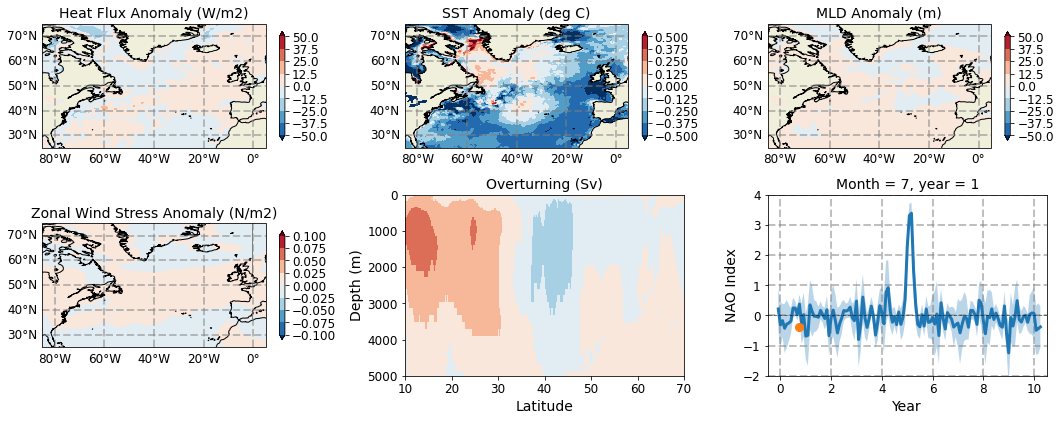

In [37]:
grid1 = plt.GridSpec(2, 3, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[18,7])

var_list = ['hfds', 'tos', 'mlotst'] #, 'tauu'] 
name = ['Heat Flux Anomaly (W/m2)', 'SST Anomaly (deg C)' , 'MLD Anomaly (m)', 'Zonal Wind Stress Anomaly (N/m2)']
val = [50., 0.5, 50., 0.1]

lat_lon_ext = [-85., 5., 25., 75.]

count = 0
axs = []
cbs = []
for var in var_list:
    
    ax = fig.add_subplot(grid1[0, count], projection=ccrs.PlateCarree(),facecolor='grey')
    
    titl = str(name[count])
    
    tmp = ds_NAOp[var].isel(time=20)
    
    [p, cb] = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
                    lon='longitude', lat='latitude', cmap='RdBu_r', title=str(name[count]))
    
    count = count + 1
    
    axs.append(ax)
    cbs.append(cb)
    
ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')

titl = str(name[3])
tmp = tauu_NAOp['tauu'].isel(time=20)

[p, cb] = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
             lon='lon', lat='lat', cmap='RdBu_r', title=str(name[count]))

axs.append(ax)
cbs.append(cb)

ax = fig.add_subplot(grid1[1, 1])
    
tmp = psiz_NAOp.isel(time_counter=0)
tmp = tmp.assign_coords(y=ds_anom.nav_lat.isel(x=0), time_counter=20)
p = tmp.plot(ax=ax, x='nav_lat', y='depthw', vmin=-1.5, vmax=1.5, levels = 9, 
            cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.8) 
ax.set_ylabel('Depth (m)', fontsize=14)
ax.set_xlabel('Latitude', fontsize=14)
ax.set_ylim([0., 5000.])
ax.set_xlim([10., 70.])
plt.gca().invert_yaxis()
plt.title('Overturning (Sv)', fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

axs.append(ax)
cbs.append(cb)

ax = fig.add_subplot(grid1[1, 2])

titl = ('Month = ' + str(ds_NAOp['time.month'].isel(time=20).values) + ', year = ' + 
        str(ds_NAOp['time.year'].isel(time=20).values -1961))
tmp = NAOp.mean(['start_year','r'])
tmp_std = NAOp.std(['start_year','r'])

count_NAOp = xr.where(NAO_season.isel(time=tim_ind) >= NAO_cut, 1, 0)
count_NAOn = xr.where(NAO_season.isel(time=tim_ind) <= -NAO_cut, 1, 0)

N = count_NAOp.sum().values # 7 days decorrelation time
ci = 1.96 # coefficiet for large N and 95% confidence interval
std_err = (ci/np.sqrt(np.ceil(N)))
tim = (ds_NAOp['time.month'].isel(time=slice(0,10+1)).values/12 
        + ds_NAOp['time.year'].isel(time=slice(0,10+1)).values -1961)

ax.plot(ds_NAOp['time.month'].values/12 + ds_NAOp['time.year'].values -1961, tmp, lw=3.)
ax.fill_between(ds_NAOp['time.month'].values/12 + ds_NAOp['time.year'].values - 1961, 
                (tmp.values - std_err*tmp_std.values), 
                    (tmp.values + std_err*tmp_std.values), alpha=0.3)
ax.plot(tim[-1], tmp.values[-1], 'o', ms=8)
ax.set_ylabel('NAO Index', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_title(titl, fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_ylim([-2., 4.])
ax.set_xlim([-0.5, 10.5])
ax.axhline(y=0, ls='-.', lw=0.5, color='k')
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)

axs.append(ax)

#axs[4].remove()
cbs[4].remove()

In [41]:
%%time

case = 'NAOp'
#case = 'NAOn'

# Define the meta data for the movie
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='NAO, Winds, SST, Heat flux', artist='Matplotlib',
                comment='Surface anomaly fields from DePreSys4 Met Office output')
writer = FFMpegWriter(fps=3, metadata=metadata)

grid1 = plt.GridSpec(2, 3, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[18,7])

var_list = ['hfds', 'tos', 'mlotst'] #, 'tauu'] 
name = ['Heat Flux Anomaly (W/m2)', 'SST Anomaly (deg C)' , 'MLD Anomaly (m)', 'Zonal Wind Stress Anomaly (N/m2)']
val = [50., 0.5, 50., 0.1]

lat_lon_ext = [-85., 5., 25., 75.]

count_NAOp = xr.where(NAO_season.isel(time=tim_ind) >= NAO_cut, 1, 0)
count_NAOn = xr.where(NAO_season.isel(time=tim_ind) <= -NAO_cut, 1, 0)

if (case == 'NAOp'):
    N = count_NAOp.sum().values # 7 days decorrelation time
elif(case == 'NAOn'):
    N = count_NAOn.sum().values
else:
    print('Choose valid case')
    
ci = 1.96 # coefficiet for large N and 95% confidence interval
std_err = (ci/np.sqrt(np.ceil(N)))

fig.patch.set_facecolor('white')

file_name = "/home/users/hkhatri/Plots/" + case + "_JFM_ind_" + str(tim_ind) + "_Composite.mp4"
with writer.saving(fig, file_name, 300): # set dpi
    
    for i in range(0, len(ds_NAOp.time)):
        
        #print(ds_NAOp['time.year'].values[i])
        
        axs = []
        cbs = []
        
        count = 0
        for var in var_list:

            ax = fig.add_subplot(grid1[0, count], projection=ccrs.PlateCarree(),facecolor='grey')

            titl = str(name[count])

            if (case == 'NAOp'):
                tmp = ds_NAOp[var].isel(time=i)
            elif(case == 'NAOn'):
                tmp = ds_NAOn[var].isel(time=i)

            [p, cb] = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
                            lon='longitude', lat='latitude', cmap='RdBu_r', title=str(name[count]))

            count = count + 1
            
            axs.append(ax)
            cbs.append(cb)

        ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')

        titl = str(name[3])
        
        if (case == 'NAOp'):
            tmp = tauu_NAOp['tauu'].isel(time=i)
        elif(case == 'NAOn'):
            tmp = tauu_NAOn['tauu'].isel(time=i)

        [p, cb] = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
                     lon='lon', lat='lat', cmap='RdBu_r', title=str(name[count]))
        
        axs.append(ax)
        cbs.append(cb)
        
        ax = fig.add_subplot(grid1[1, 1])
        
        if (case == 'NAOp'):
            tmp = psiz_NAOp.isel(time_counter=i)
        elif(case == 'NAOn'):
            tmp = psiz_NAOn.isel(time_counter=i)
            
        tmp = tmp.assign_coords(y=ds_anom.nav_lat.isel(x=0), time_counter=0)
        p = tmp.plot(ax=ax, x='nav_lat', y='depthw', vmin=-1.5, vmax=1.5, levels = 9, 
                    cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
        cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.8) 
        ax.set_ylabel('Depth (m)', fontsize=14)
        ax.set_xlabel('Latitude', fontsize=14)
        #plt.xticks(np.arange(20,70,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
        ax.set_ylim([0., 5000.])
        ax.set_xlim([10., 70.])
        plt.gca().invert_yaxis()
        plt.title('Overturning Anomaly (Sv)', fontsize=14)
        plt.yticks(fontsize = 12)
        plt.xticks(fontsize = 12)

        axs.append(ax)
        cbs.append(cb)
        
        ax = fig.add_subplot(grid1[1, 2])

        titl = ('Month = ' + str(ds_NAOp['time.month'].isel(time=i).values) + 
                ', year = ' + str(ds_NAOp['time.year'].isel(time=i).values -1961))
        
        if (case == 'NAOp'):
            tmp = NAOp.isel(time=slice(0,i+1)).mean(['start_year','r'])
            tmp_std = NAOp.isel(time=slice(0,i+1)).std(['start_year','r'])
        elif(case == 'NAOn'):
            tmp = NAOn.isel(time=slice(0,i+1)).mean(['start_year','r'])
            tmp_std = NAOn.isel(time=slice(0,i+1)).std(['start_year','r'])
            
        
        tim = (ds_NAOp['time.month'].isel(time=slice(0,i+1)).values/12 
               + ds_NAOp['time.year'].isel(time=slice(0,i+1)).values -1961)

        ax.plot(tim, tmp, lw=3.)
        ax.fill_between(tim, (tmp.values - std_err*tmp_std.values), 
                            (tmp.values + std_err*tmp_std.values), alpha=0.3)
        ax.plot(tim[-1], tmp.values[-1], 'o', ms=7)
        ax.set_ylabel('NAO Index', fontsize=14)
        ax.set_xlabel('Year', fontsize=14)
        ax.set_title(titl, fontsize=14)
        plt.yticks(fontsize=12)
        plt.xticks(fontsize=12)
        if (case == 'NAOp'):
            ax.set_ylim([-2., 4.])
        elif(case == 'NAOn'):
            ax.set_ylim([-4., 2.])
        ax.set_xlim([-0.5, 10.5])
        ax.axhline(y=0, ls='-.', lw=0.5, color='k')
        ax.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)
        
        axs.append(ax)
        
        plt.tight_layout();
        
        writer.grab_frame();
        
        for ax1 in axs:
            ax1.remove();
        for cb1 in cbs:
            cb1.remove();

CPU times: user 6min 4s, sys: 29.7 s, total: 6min 34s
Wall time: 6min 52s


<Figure size 1296x504 with 0 Axes>

### Plot for Feb 2022 report

DJF anomalies corresponding to NAO+ and NAO- phases

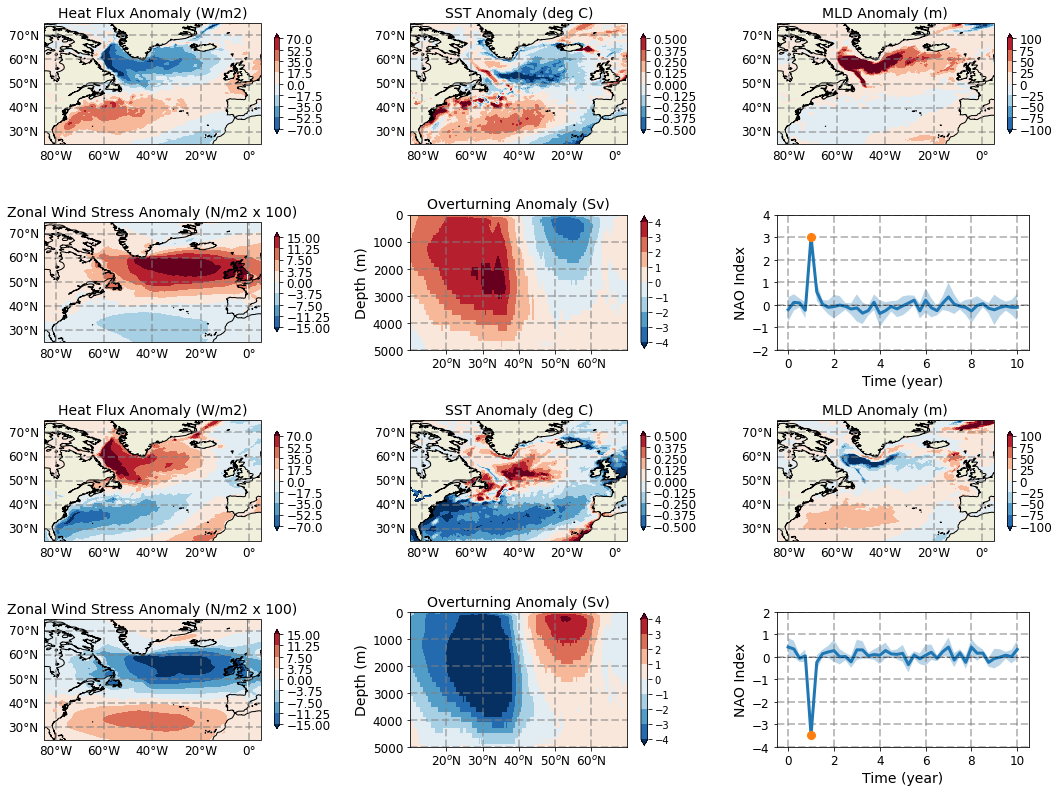

In [59]:
tim_ind =4

grid1 = plt.GridSpec(4, 3, wspace=0.35, hspace=0.2)
fig = plt.figure(figsize=[18,14])

var_list = ['hfds', 'tos', 'mlotst'] #, 'tauu'] 
name = ['Heat Flux Anomaly (W/m2)', 'SST Anomaly (deg C)' , 'MLD Anomaly (m)', 'Zonal Wind Stress Anomaly (N/m2 x 100)']
val = [70., 0.5, 100., 15]

lat_lon_ext = [-85., 5., 25., 75.]

case_list = ['NAOp', 'NAOn']

for case in case_list: 

    count = 0

    for var in var_list:

        titl = str(name[count])
        
        # get seasonl mean for the relavant data
        if (case == 'NAOp'):
            ax = fig.add_subplot(grid1[0, count], projection=ccrs.PlateCarree(),facecolor='grey')
            tmp = ds_NAOp[var].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+1+3)).mean('time')
        elif(case == 'NAOn'):
            ax = fig.add_subplot(grid1[2, count], projection=ccrs.PlateCarree(),facecolor='grey')
            tmp = ds_NAOn[var].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+1+3)).mean('time')
            
        [p, cb] = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
                        lon='longitude', lat='latitude', cmap='RdBu_r', title=str(name[count]))

        count = count + 1

    titl = str(name[3])
    
    if (case == 'NAOp'):
        ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
        tmp = tauu_NAOp['tauu'].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+1+3)).mean('time')
    elif(case == 'NAOn'):
        ax = fig.add_subplot(grid1[3, 0], projection=ccrs.PlateCarree(),facecolor='grey')
        tmp = tauu_NAOn['tauu'].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+1+3)).mean('time')

    [p, cb] = plot_sec(ax, tmp*100, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
                 lon='lon', lat='lat', cmap='RdBu_r', title=str(name[count]))

    if (case == 'NAOp'):
        ax = fig.add_subplot(grid1[1, 1])
        tmp = psiz_NAOp.isel(time_counter=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+1+3)).mean('time_counter')
    elif(case == 'NAOn'):
        ax = fig.add_subplot(grid1[3, 1])
        tmp = psiz_NAOn.isel(time_counter=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+1+3)).mean('time_counter')
        
    tmp = tmp.assign_coords(y=ds_anom.nav_lat.isel(x=0), time_counter=20)
    p = tmp.plot(ax=ax, x='nav_lat', y='depthw', vmin=-4.0, vmax=4.0, levels = 9, 
                cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.8) 
    ax.set_ylabel('Depth (m)', fontsize=14)
    #ax.set_xlabel('Latitude', fontsize=14)
    plt.xticks(np.arange(20,70,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
    ax.set_ylim([0., 5000.])
    ax.set_xlim([10., 70.])
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)
    plt.gca().invert_yaxis()
    plt.title('Overturning Anomaly (Sv)', fontsize=14)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
    bbox=plt.gca().get_position()
    offset=.03
    plt.gca().set_position([bbox.x0 , bbox.y0 + offset*0.5 , bbox.x1-bbox.x0, bbox.y1 - bbox.y0 - offset])

    if (case == 'NAOp'):
        ax = fig.add_subplot(grid1[1, 2])
        tmp = NAO_season.where(NAO_season.isel(time=tim_ind) >= NAO_cut)
        count_NAOp = xr.where(NAO_season.isel(time=tim_ind) >= NAO_cut, 1, 0)
        N = count_NAOp.sum().values # 7 days decorrelation time
    elif(case == 'NAOn'):
        ax = fig.add_subplot(grid1[3, 2])
        tmp = NAO_season.where(NAO_season.isel(time=tim_ind) <= -NAO_cut)
        count_NAOn = xr.where(NAO_season.isel(time=tim_ind) <= -NAO_cut, 1, 0)
        N = count_NAOn.sum().values # 7 days decorrelation time
    
    tmp_std = tmp.std(['start_year','r'])
    tmp = tmp.mean(['start_year','r'])

    ci = 1.96 # coefficiet for large N and 95% confidence interval
    std_err = (ci/np.sqrt(np.ceil(N)))
    
    tim = np.arange(0,41)

    ax.plot(tim / 4, tmp, lw=3.)
    ax.fill_between(tim / 4, (tmp.values - std_err*tmp_std.values), (tmp.values + std_err*tmp_std.values), alpha=0.3)
    ax.plot(tim[tim_ind] / 4, tmp.values[tim_ind], 'o', ms=8)
    ax.set_ylabel('NAO Index', fontsize=14)
    ax.set_xlabel('Time (year)', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    if (case == 'NAOp'):
        ax.set_ylim([-2., 4.])
    elif(case == 'NAOn'):
        ax.set_ylim([-4., 2.])
    ax.set_xlim([-0.5, 10.5])
    ax.axhline(y=0, ls='-.', lw=0.5, color='k')
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)
    
    bbox=plt.gca().get_position()
    offset=.03
    plt.gca().set_position([bbox.x0 , bbox.y0 + offset*0.5 , bbox.x1-bbox.x0 - offset*0.5, bbox.y1 - bbox.y0 - offset])

#fig.savefig('/home/users/hkhatri/Plots/Report_Feb_2022.png',dpi=150,bbox_inches='tight');